In [43]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [44]:
import gym
import numpy as np
from gym import spaces
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

class MyCustomEnv(Env):
    def __init__(self):
        super(MyCustomEnv, self).__init__()

        # 物理参数
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masscart + self.masspole
        self.length = 0.5
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02
        self.spring_constant = 10.0  # 弹簧系数，可以根据需要调整

        # 终止条件的角度阈值
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 5

        # 观测空间和动作空间
        self.action_space = spaces.Discrete(21)  # 21个连续动作
        self.observation_space1 = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)  # 两个智能体的状态
        self.observation_space2 = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)  # 两个智能体的状态
        
        # 初始化状态
        self.state1 = np.zeros(8)
        self.state2 = np.zeros(4）

        
    def step(self, action1,action2,action3):
        actions = (action1, action2, action3)
        #assert self.action_space.contains(actions), f"{actions!r} ({type(actions)}) invalid"
        #assert self.state1 is not None, "Call reset before using step method."

        # 分别计算两个倒立摆的动力学
        x1, x1_dot, theta1, theta1_dot, x2, x2_dot, theta2, theta2_dot = self.state1
        x3, x3_dot, theta3, theta3_dot = self.state2
        
        f1= action1
        f2= action2
        f3= action3
        
        # 计算弹簧力
        spring_force1 = -self.spring_constant * (x1 - x2 + 1)
        spring_force2 = -self.spring_constant * (x2 - x3 + 1)
       
        # 智能体1的动力学
        costheta1 = np.cos(theta1)
        sintheta1 = np.sin(theta1)
        temp1 = (f1-10 + spring_force1 + self.polemass_length * theta1_dot**2 * sintheta1) / self.total_mass
        thetaacc1 = (self.gravity * sintheta1 - costheta1 * temp1) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta1**2 / self.total_mass))
        xacc1 = temp1 - self.polemass_length * thetaacc1 * costheta1 / self.total_mass

        # 智能体2的动力学
        costheta2 = np.cos(theta2)
        sintheta2 = np.sin(theta2)
        temp2 = (f2-10 - spring_force1 + spring_force2 + self.polemass_length * theta2_dot**2 * sintheta2) / self.total_mass
        thetaacc2 = (self.gravity * sintheta2 - costheta2 * temp2) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta2**2 / self.total_mass)
        )
        xacc2 = temp2 - self.polemass_length * thetaacc2 * costheta2 / self.total_mass
        
        # 智能体3的动力学
        costheta3 = np.cos(theta3)
        sintheta3 = np.sin(theta3)
        temp3 = (f3-10 - spring_force2 + self.polemass_length * theta3_dot**2 * sintheta3) / self.total_mass
        thetaacc3 = (self.gravity * sintheta3 - costheta3 * temp3) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta3**2 / self.total_mass)
        )
        xacc3 = temp3 - self.polemass_length * thetaacc3 * costheta3 / self.total_mass
        
        # 更新状态
        x1_dot = x1_dot + self.tau * xacc1
        x2_dot = x2_dot + self.tau * xacc2
        x3_dot = x3_dot + self.tau * xacc3
        theta1_dot = theta1_dot + self.tau * thetaacc1
        theta2_dot = theta2_dot + self.tau * thetaacc2
        theta3_dot = theta3_dot + self.tau * thetaacc3
        x1 = x1 + self.tau * x1_dot
        x2 = x2 + self.tau * x2_dot
        x3 = x3 + self.tau * x3_dot

        self.state1 = np.array([x1, x1_dot, theta1, theta1_dot, x2, x2_dot, theta2, theta2_dot])
        self.state2 = np.array([x3, x3_dot, theta3, theta3_dot])
        # 检查是否终止
        terminated1 = np.abs(x1) >= self.x_threshold or np.abs(theta1) >= self.theta_threshold_radians or \
                      np.abs(x2) >= self.x_threshold or np.abs(theta2) >= self.theta_threshold_radians 
        terminated2 = np.abs(x3) >= self.x_threshold or np.abs(theta3) >= self.theta_threshold_radians
        terminated = terminated1 or terminated2
        # 计算奖励
        # 智能体1获胜：x1在x2的右边且x2在终止区域内
        # 智能体2获胜：x2在x1的左边且x1在终止区域内


        if terminated:
            if terminated1:
                reward1 = -99
                reward2 = -99
                reward3 = 501
            elif terminated2:
                reward1 = 1
                reward2 = 1
                reward3 = -99 
        else:
                reward1 = 1
                reward2 = 1
                reward3 = 1
        
        return self.state1,self.state2, reward1,reward2,reward3, terminated1,terminated2,terminated, {}

    def reset(self):
        self.state1 = np.array([-1+random.uniform(-0.1, 0.1), 0, 0+random.uniform(-0.1, 0.1), 0 , 0+random.uniform(-0.1, 0.1), 0, 0+random.uniform(-0.1, 0.1), 0])
        self.state2 = np.array([1+random.uniform(-0.1, 0.1), 0, 0+random.uniform(-0.1, 0.1), 0 ])
        return self.state1[:8],self.state2[:4]

    def render(self):
        # 渲染逻辑（需要实现）
        pass


    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False


# 假设环境类MyEnv定义在当前脚本中，即__main__模块



# 使用环境

env = MyCustomEnv()

In [45]:
class ReplayBuffer:
    ''' 智能体3的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, next_action, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, next_action, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, next_action, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), next_action, done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [46]:
class ReplayBuffer1:
    '''智能体1和2的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state1, action1, action2, reward1, next_state1, next_action1, next_action2, done):  # 将数据加入buffer
        self.buffer.append((state1,action1, action2, reward1, next_state1, next_action1, next_action2, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state1, action1, action2, reward1, next_state1, next_action1, next_action2, done = zip(*transitions)
        return np.array(state1), action1, action2, reward1, np.array(next_state1), next_action1, next_action2, done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [47]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [48]:
class SARSA:
    ''' 智能体3的SARSA算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        next_actions = torch.tensor(transition_dict['next_actions']).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        next_q_values = self.q_net(next_states).gather(1, next_actions.view(-1, 1))
        
        q_targets = rewards + self.gamma *  next_q_values * (1 - dones)  # TD误差目标
        sarsa_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        sarsa_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [49]:
class SARSA1:
    ''' 智能体1和2的SARSA算法 '''
    def __init__(self, state_dim1, hidden_dim, action_dim1, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim1
        #智能体1
        self.q_net1 = Qnet(8, hidden_dim,
                          self.action_dim* self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net1 = Qnet(8, hidden_dim,
                                 self.action_dim*self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer1 = torch.optim.Adam(self.q_net1.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state1):  # epsilon-贪婪策略采取动作
        action1 = 0
        action2 = 0
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim*self.action_dim)
        else:
            state_tensor = torch.tensor([state1], dtype=torch.float).to(self.device)
            action = self.q_net1(state_tensor).argmax().item()
            action1 = action // 21
            action2 = action % 21   
        return action1, action2

    def update(self, transition_dict):
        state1s = torch.tensor(transition_dict['state1s'],
                              dtype=torch.float).to(self.device)
        action1s = torch.tensor(transition_dict['action1s']).view(-1, 1).to(self.device)
        action2s = torch.tensor(transition_dict['action2s']).view(-1, 1).to(self.device)
        reward1s = torch.tensor(transition_dict['reward1s'],dtype=torch.float).view(-1, 1).to(self.device)
        next_state1s = torch.tensor(transition_dict['next_state1s'],dtype=torch.float).to(self.device)
        next_action1s = torch.tensor(transition_dict['next_action1s']).view(-1, 1).to(self.device)
        next_action2s = torch.tensor(transition_dict['next_action2s']).view(-1, 1).to(self.device)        
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        actions = action1s * self.action_dim + action2s
        next_actions = next_action1s * self.action_dim + next_action2s
        q1_values = self.q_net1(state1s).gather(1, actions)  # Q值

        # 下个动作的Q值
        next_q_value1s = self.q_net1(next_state1s).gather(1, next_actions.view(-1, 1))
        #next_q_value1s = self.q_net1(next_state1s).gather(1, next_actions.view(-1, 1))
        q_targets = reward1s + self.gamma *  next_q_value1s * (1 - dones)  # TD误差目标
        sarsa_loss = torch.mean(F.mse_loss(q1_values, q_targets))  # 均方误差损失函数
        self.optimizer1.zero_grad()
        sarsa_loss.backward()
        self.optimizer1.step()
        if self.count % self.target_update == 0:
            self.target_q_net1.load_state_dict(self.q_net1.state_dict())  # 更新目标网络
        self.count += 1

In [56]:
# pip install gym==0.25.2
lr = 2e-3
num_episodes = 2500
hidden_dim = 128
gamma = 0.9
epsilon = 0.015
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
batch_size1 = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

#env_name = 'CartPole-v0'
#env = gym.make(env_name)


# random.seed(0)
# np.random.seed(0)
# env.seed(0)
# torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
replay_buffer1 = ReplayBuffer1(buffer_size)
state_dim1= env.observation_space1.shape[0]
state_dim = env.observation_space2.shape[0]
action_dim = env.action_space.n
action_dim1 = env.action_space.n
agent = SARSA(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
agent1 = SARSA1(state_dim1, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list = []
return_list1 = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            episode_return1 = 0
            state1, state= env.reset()
            count=0
            action=agent.take_action(state)
            action1,action2 = agent1.take_action(state1)
            done = False
            while not done and count<200:
                count+=1

                next_state1, next_state, reward1,reward2,reward, terminated1,terminated2,done,info = env.step(action1,action2,action)
                next_action=agent.take_action(next_state)
                next_action1,next_action2 = agent1.take_action(next_state1)
                #next_state, reward, done, _, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, next_action, done)
                replay_buffer1.add(state1, action1, action2, reward1, next_state1, next_action1, next_action2, done)
                
                action = next_action
                action1 = next_action1
                action2 = next_action2
                state = next_state
                state1 = next_state1
                
                #print(state1)
                episode_return += reward
                episode_return1 += reward1
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_na, b_d = replay_buffer.sample(batch_size)
          
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'next_actions':b_na,
                        'dones': b_d
                    }

                    agent.update(transition_dict)
                if replay_buffer1.size() > minimal_size:                   
                    c_s1, c_a1, c_a2, c_r, c_ns1, c_na1, c_na2, c_d = replay_buffer1.sample(batch_size1)
                    #print(c_ns1)
                    transition_dict1 = {
                        'state1s': c_s1,
                        'action1s': c_a1,
                        'action2s': c_a2,
                        'reward1s': c_r,
                        'next_state1s': c_ns1,
                        'next_action1s':c_na1,
                        'next_action2s':c_na2,
                        'dones': c_d
                    }
                    agent1.update(transition_dict1)
                           
            return_list.append(episode_return)
            return_list1.append(episode_return1)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s, episode=250, return=314.400]
Iteration 1: 100%|██████████| 250/250 [02:50<00:00,  1.47it/s, episode=500, return=295.100]
Iteration 2: 100%|██████████| 250/250 [02:38<00:00,  1.58it/s, episode=750, return=389.200]
Iteration 3: 100%|██████████| 250/250 [02:52<00:00,  1.45it/s, episode=1000, return=236.800]
Iteration 4: 100%|██████████| 250/250 [02:44<00:00,  1.52it/s, episode=1250, return=258.500]
Iteration 5: 100%|██████████| 250/250 [02:44<00:00,  1.52it/s, episode=1500, return=241.200]
Iteration 6: 100%|██████████| 250/250 [02:54<00:00,  1.43it/s, episode=1750, return=264.000]
Iteration 7: 100%|██████████| 250/250 [02:43<00:00,  1.52it/s, episode=2000, return=323.100]
Iteration 8: 100%|██████████| 250/250 [02:41<00:00,  1.55it/s, episode=2250, return=167.500]
Iteration 9: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, episode=2500, return=217.100]

Iteration 9: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, episode=2500, return=217.100]


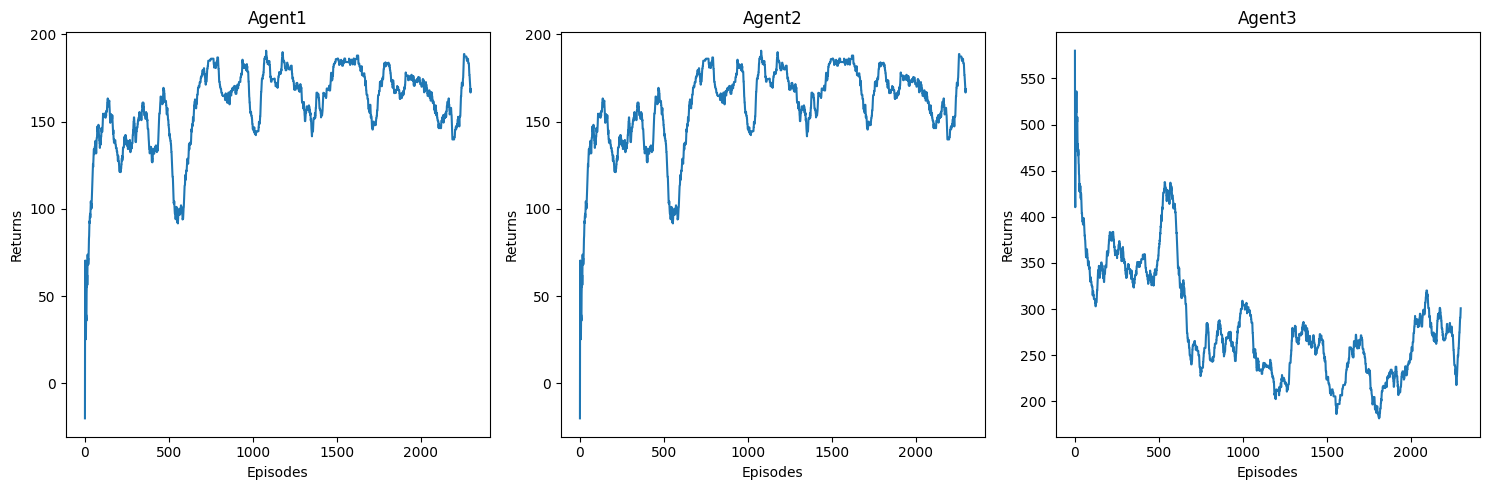

In [99]:

episodes_list = list(range(len(return_list)))
# 计算移动平均回报
mv_return1 = rl_utils.moving_average(return_list1, 69)
mv_return2 = rl_utils.moving_average(return_list1, 69)  
mv_return = rl_utils.moving_average(return_list, 99)

# 创建一个包含3个子图的图形窗口
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1行3列

# 绘制Agent1的移动平均回报
axs[0].plot(episodes_list[0:2300], mv_return1[0:2300])
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Returns')
axs[0].set_title('Agent1')

# 绘制Agent2的移动平均回报
axs[1].plot(episodes_list[0:2300], mv_return2[0:2300])  # 确保这里使用Agent2的数据
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Returns')
axs[1].set_title('Agent2')

# 绘制Agent3的移动平均回报
axs[2].plot(episodes_list[0:2300], mv_return[0:2300])
axs[2].set_xlabel('Episodes')
axs[2].set_ylabel('Returns')
axs[2].set_title('Agent3')

# 调整子图间距
plt.tight_layout()

# 展示图表
plt.show()